<a href="https://colab.research.google.com/github/Tanzir11/Yolov8-Object-Counting/blob/main/Object_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [2]:
pwd

'/content/gdrive/MyDrive'

In [3]:
!mkdir "Counting"

mkdir: cannot create directory ‘Counting’: File exists


In [4]:
%cd /content/gdrive/MyDrive/Counting

/content/gdrive/MyDrive/Counting


In [5]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.92 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.4/107.7 GB disk)


In [6]:
!git clone https://github.com/abewley/sort.git

fatal: destination path 'sort' already exists and is not an empty directory.


In [7]:
from ultralytics import YOLO

In [9]:
model = YOLO()

In [ ]:
model = YOLO("/content/gdrive/MyDrive/Counting/weights/Floki.pt") # i am using the custom model named Floki.pt

In [10]:
pip install cvzone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.5.6-py3-none-any.whl size=18766 sha256=cb76ffaebdba6adda483a61a36094912d32ac63b5a67f6451c802c2a08d08bc3
  Stored in directory: /root/.cache/pip/wheels/d8/85/f1/1756f9e009d280be742fb20dd5087c60c2f7f0279964934375
Successfully built cvzone


In [11]:
import math
import cvzone

In [12]:
# These are all the classes that the yolo model is trained on
classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
           'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
           'handbag', 'tie', 'suitcase', 'frisbee', 'skis','snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
           'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
           'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
           'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [13]:
SOURCE_VIDEO_PATH='/content/gdrive/MyDrive/Counting/Rendered/output2.mp4'

In [14]:
!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

from IPython import display
display.clear_output()


import sys
sys.path.append(f"ByteTrack")

In [15]:
pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached loguru-0.7.0-py3-none-any.whl (59 kB)


In [16]:
pip install lap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1655257 sha256=ac34a8ca9453c9f1a9be95de4512fe0931827a0723e16d9828a6fba8c28e84ec
  Stored in directory: /root/.cache/pip/wheels/00/42/2e/9dfe19270eea279d79e84767ff0d7b8082c3bf776cad00e83d
Successfully built lap


In [17]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [18]:
# Getting the supervision
!pip install supervision==0.1.0
import supervision
from supervision.video.dataclasses import VideoInfo
source_video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
source_video_info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


VideoInfo(width=1920, height=1080, fps=23, total_frames=627)

In [19]:
# Dependencies that we'll be using
from supervision.draw.color import ColorPalette
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [20]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [21]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
CLASS_ID = [39, 60, 63]


0: 384x640 1 person, 267.5ms
Speed: 16.2ms preprocess, 267.5ms inference, 26.6ms postprocess per image at shape (1, 3, 640, 640)


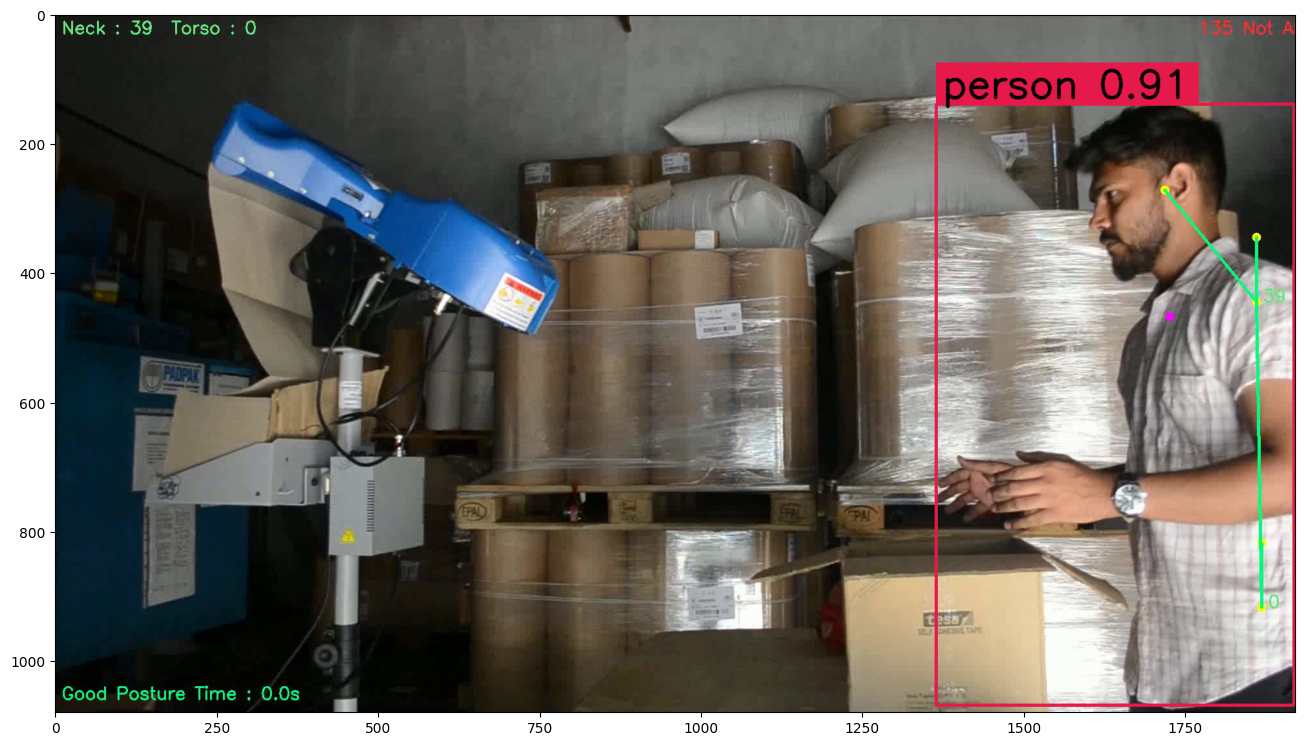

In [22]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame,classes=[0,56])
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [23]:
# Points that will get placed upon the video to draw the line and it will get counted
from supervision.geometry.dataclasses import Point
LINE_START = Point(900,0)
LINE_END = Point(900,1200)

In [24]:
# This is where the video will get saved
TARGET_VIDEO_PATH = "/content/gdrive/MyDrive/Counting/Newest.mp4"

Below code will count the number of object that have passed through the line

In [ ]:
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame, classes=[0])
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # counter.add(int(class_id))
        # cvzone.putTextRect(frame, f'Counter: {len(tracker_id)}',(0,20), scale=2.0, thickness=2, offset=3)
        # # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

Below code will count the number of objects present in the frame

In [ ]:
from tqdm.notebook import tqdm

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2
font_thickness = 3
text_color = (0, 0, 0) # Black
text_origin = (50, 50)

# create counters for humans and chairs
human_counter = set()
chair_counter = set()

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())

video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

  # loop over video frames
  for frame in tqdm(generator, total=video_info.total_frames):
      # model prediction on single frame and conversion to supervision Detections
      results = model(frame, classes=[0, 56])
      detections = Detections(
          xyxy=results[0].boxes.xyxy.cpu().numpy(),
          confidence=results[0].boxes.conf.cpu().numpy(),
          class_id=results[0].boxes.cls.cpu().numpy().astype(int)
          )
      # filtering out detections with unwanted classes
      mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
      detections.filter(mask=mask, inplace=True)
      # tracking detections
      tracks = byte_tracker.update(
          output_results=detections2boxes(detections=detections),
          img_info=frame.shape,
          img_size=frame.shape
          )
      tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
      detections.tracker_id = np.array(tracker_id)
      # filtering out detections without trackers
      mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
      detections.filter(mask=mask, inplace=True)
      # format custom labels and update counters
      human_ids = set()
      chair_ids = set()
      # counter.add(int(class_id))
      cv2.rectangle(frame, (0,0), (2700,100), (255,255,255), -1)
      for _, confidence, class_id, tracker_id in detections:
          label = f"{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
          if class_id == 0:  # human class
              human_ids.add(tracker_id)
          elif class_id == 56:  # chair class
              chair_ids.add(tracker_id)
          labels.append(label)
      human_counter.update(human_ids)
      chair_counter.update(chair_ids)
      cv2.putText(frame, f'Counter: {len(human_counter)} | Vacant: {(len(chair_counter)-len(human_counter))}', text_origin, font, font_scale, text_color, font_thickness)
      frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
      sink.write_frame(frame)

Below code does the same but with beetter presentation

In [ ]:
# classnames = ["person","chair"]
cap = cv2.VideoCapture("/content/gdrive/MyDrive/Counting/output_segment_12.mp4")

cod = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('yolo.mp4', cod, 30.0, (480, 848))
while True:
    success, img = cap.read()
    results=model(img,classes = [0,56])
    detections = np.empty((0,5))
    for r in results:
        boxes = r.boxes
        for box in boxes:
            #Bounding Box
            x1,y1,x2,y2=box.xyxy[0]
            x1,y1,x2,y2=int(x1), int(y1), int(x2), int(y2)
            
            w,h = x2-x1, y2-y1
            conf=math.ceil((box.conf[0]*100))/100
            cls = int(box.cls[0])
            human_counter = []
            chair_counter = []
            currentclass=classes[cls]
            if currentclass=="person":
                cvzone.putTextRect(img, f'{classes[cls]}', (max(0,x1),max(35,y1)), scale=0.6, thickness=1, offset=3)
                cvzone.cornerRect(img, (x1,y1,w,h),l=9)
                currentarray= np.array([x1,y1,x2,y2,conf])
                detections=np.vstack((detections, currentarray))
                human_counter.append(cls)
            elif currentclass=="chair":
                cvzone.putTextRect(img, f'{classes[cls]}', (max(0,x1),max(35,y1)), scale=0.6, thickness=1, offset=3)
                cvzone.cornerRect(img, (x1,y1,w,h),l=9)
                currentarray= np.array([x1,y1,x2,y2,conf])
                detections=np.vstack((detections, currentarray))
                chair_counter.append(cls)
    cv2.putText(img, f'Humans: {len(human_counter)} | Vacant: {(len(chair_counter)-len(human_counter))}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    out.write(img)
    cv2.waitKey(1)